<a href="https://colab.research.google.com/github/ynukou/TSAD/blob/main/TSAD_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # Load google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

In [ ]:
ROOT = '/content/drive/MyDrive/datasets/NumentaAnomalyBenchmark/'
SMALL_NOISE_PATH = 'artificialNoAnomaly/art_daily_small_noise.csv'
DAILY_JUMPSUP_PATH = 'artificialWithAnomaly/art_daily_jumpsup.csv'

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Data preprocessing

In [ ]:
df_small_noise = pd.read_csv(
    ROOT + SMALL_NOISE_PATH, parse_dates=True, index_col='timestamp'
)
df_daily_jumpsup = pd.read_csv(
    ROOT + DAILY_JUMPSUP_PATH, parse_dates=True, index_col='timestamp'
)

In [ ]:
print(df_small_noise.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120


In [ ]:
print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


In [ ]:
def visualize_timeserie(serie: pd.DataFrame, legend:bool = False) -> None:
    fig, ax = plt.subplots(figsize=(15, 4))
    serie.plot(ax=ax, legend=legend)
    if legend:
        plt.legend()
    plt.show()

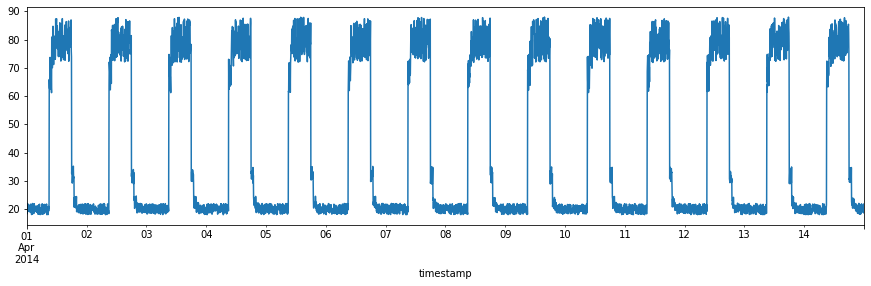

In [ ]:
visualize_timeserie(df_small_noise)

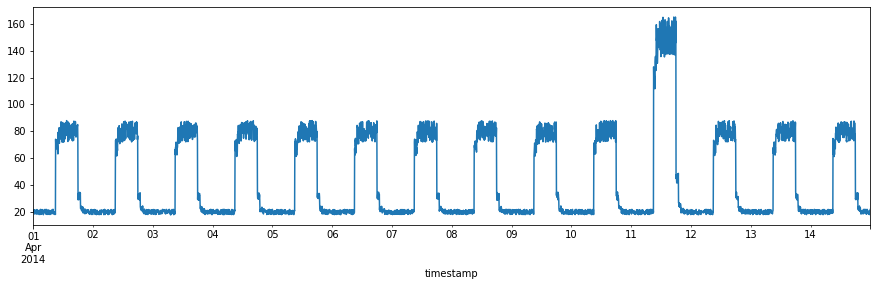

In [ ]:
visualize_timeserie(df_daily_jumpsup)

In [ ]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training = (df_small_noise - training_mean) / training_std
df_training.shape

(4032, 1)

In [ ]:
#TIME_STEPS = 24 * 60 / 5 #每天有24 * 60 / 5个时间步
TIME_STEPS = 288 #每天有288个时间步

def create_sequences(values: np.ndarray, time_steps: int = TIME_STEPS) -> torch.FloatTensor:
    # Create daily sequences
    output = [values[i:(i + time_steps)] for i in range(len(values) - time_steps)]
    print(output)
    return torch.FloatTensor(output).permute(0, 2, 1)

In [ ]:
X = create_sequences(df_training.values)
# print(X)

X_train, X_valid = train_test_split(X, train_size=0.9, shuffle=False)

dataloader = {
    'train': DataLoader(X_train, batch_size=4),
    'valid': DataLoader(X_valid, batch_size=4),
}

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


# Model

class torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

in_channels(int) – 输入信号的通道。在文本分类中，即为词向量的
维度

out_channels(int) – 卷积产生的通道。有多少个out_channels，就需要多少个1维卷积

kernel_size(int or tuple) - 卷积核的尺寸，卷积核的大小为(k,)，第二个维度是由in_channels来决定的，所以实际上卷积大小为kernel_size*in_channels

stride(int or tuple, optional) - 卷积步长

padding (int or tuple, optional)- 输入的每一条边补充0的层数

dilation(int or tuple, `optional``) – 卷积核元素之间的间距

groups(int, optional) – 从输入通道到输出通道的阻塞连接数

bias(bool, optional) - 如果bias=True，添加偏置

In [ ]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=7, padding=3),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(16, 16, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(16, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 1, kernel_size=7, padding=3)
        )
        
    def forward(self, sample):
        latent = self.encoder(sample)
        reconstructed = self.decoder(latent)
        return reconstructed

# Train

In [ ]:
def train_model(
    model: nn.Module,
    dataloader: Dict[str, DataLoader],
    criterion: nn.Module,
    optimizer: nn.Module,
    epochs: int = 25
) -> Dict[str, List[float]]:
    """Training the model. Returns dictionary of train and validation losses.
    Args:
        model (torch.nn.Module): Neural network
        dataloader (Dict[str, DataLoader]):
            Dictionary with 'train' and 'valid' dataloaders
        criterion (torch.nn.Module): Cost function
        optimizer (torch.nn.Module): Optimization algorithm
        epochs (int): Number of training iterations. Default: 50
    """

    losses = {'train': [], 'valid': []}
    progress = tqdm(range(epochs), desc='Epoch')
    
    for epoch in progress:
        for phase in ['train', 'valid']:
            loss_accum = []
            model.train(mode=(phase == 'train'))
            
            for inputs in dataloader[phase]:
                inputs = inputs.to(DEVICE)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    outp = model(inputs)
                    loss = criterion(outp, inputs)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outp = model(inputs)
                        loss = criterion(outp, inputs)
                
                loss_accum.append(loss.item())
            
            phase_loss = np.mean(loss_accum)
            losses[phase].append(phase_loss)
            progress.set_description('loss: {:.4f}'.format(phase_loss))

    return losses

In [ ]:
N_EPOCHS = 50

model = Autoencoder().to(DEVICE)

losses = train_model(
    model=model,
    dataloader=dataloader,
    criterion=nn.MSELoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.0001),
    epochs=N_EPOCHS,
)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

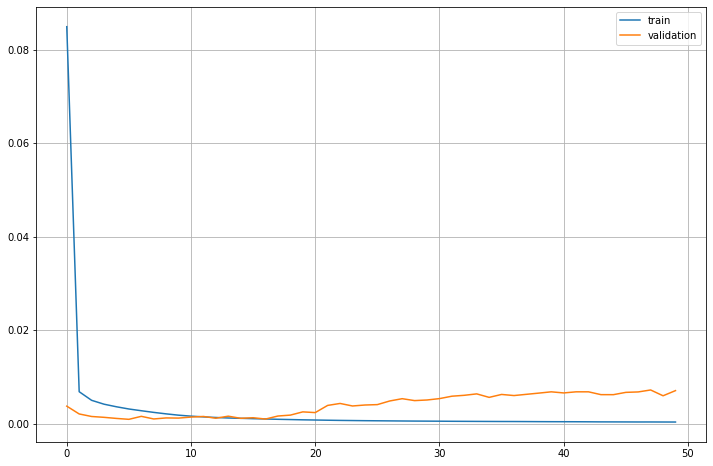

In [ ]:
def show_metrics(metrics: Dict[str, List[float]]) -> None:
    plt.figure(figsize=(12, 8))
    plt.plot(metrics['train'], label='train')
    plt.plot(metrics['valid'], label='validation')
    plt.grid()
    plt.legend()
    plt.show()

    
# look at loss function...
show_metrics(losses)

# Alarm threshold

In [ ]:
def evaluate_model(
    model: nn.Module, dataloader: DataLoader
) -> Tuple[List[float], List[float]]:
    
    losses:List[float] = list()
    preds:List[float] = list()
        
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch.to(DEVICE)).cpu().numpy()
            preds.append(pred.ravel())
            loss = np.mean(np.abs(pred - batch.numpy()))
            losses.append(loss)
    return (losses, preds)

In [ ]:
dataloader_full: DataLoader = DataLoader(X, batch_size=1)
losses, preds = evaluate_model(model=model, dataloader=dataloader_full)
            
threshold: float = 0.    
for loss in losses:
    if loss > threshold:
        threshold = loss

print(f'small_noise threshold: {threshold}')

small_noise threshold: 0.05506971478462219


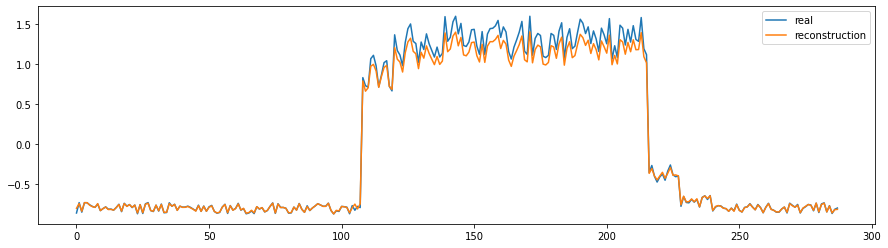

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(X_train[0].numpy().ravel(), label='real')
plt.plot(preds[0], label='reconstruction')
plt.legend()
plt.show()

# Test 1

In [ ]:
df_testing = (df_daily_jumpsup - training_mean) / training_std
x_test = create_sequences(df_testing.values)
dataloader_test = DataLoader(x_test, shuffle=False)
x_test.shape

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([3744, 1, 288])

In [ ]:
test_losses, test_preds = evaluate_model(model=model, dataloader=dataloader_test)

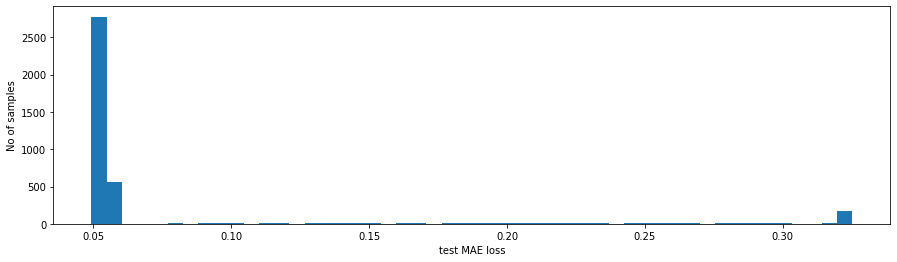

In [ ]:
plt.figure(figsize=(15, 4))
plt.hist(test_losses, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
anomalies = test_losses > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  813
Indices of anomaly samples:  (array([ 770,  771,  772,  773,  774,  775,  776,  777,  778,  779,  780,
        781,  782,  784,  793,  794,  796,  800,  803,  814,  815,  816,
        887,  890,  902,  908,  910,  911,  914,  971,  973, 1605, 1616,
       1618, 1621, 1622, 1623, 1624, 1634, 1635, 1940, 1941, 1942, 1943,
       1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955,
       1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
       1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
       1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032,
       2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2

In [ ]:
def get_anomaly_idxs(df: pd.DataFrame, anomalies: np.ndarray) -> List[int]:
    anomaly_idxs: List[int] = list()
    start = TIME_STEPS - 1
    for idx in range(start, len(df) - start):
        if np.all(anomalies[(idx - start):idx]):
            anomaly_idxs.append(idx)
    return anomaly_idxs

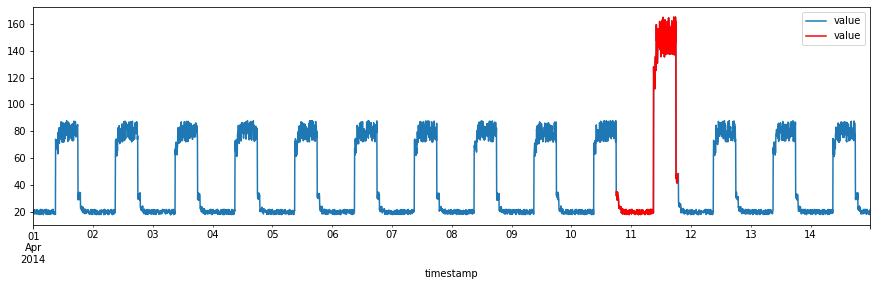

In [ ]:
anomaly_idxs = get_anomaly_idxs(dataloader_test, anomalies)
df_anomaly = df_daily_jumpsup.iloc[anomaly_idxs]

fig, ax = plt.subplots(figsize=(15, 4))
df_daily_jumpsup.plot(ax=ax)
df_anomaly.plot(ax=ax, color='red')
plt.show()

# Test 2

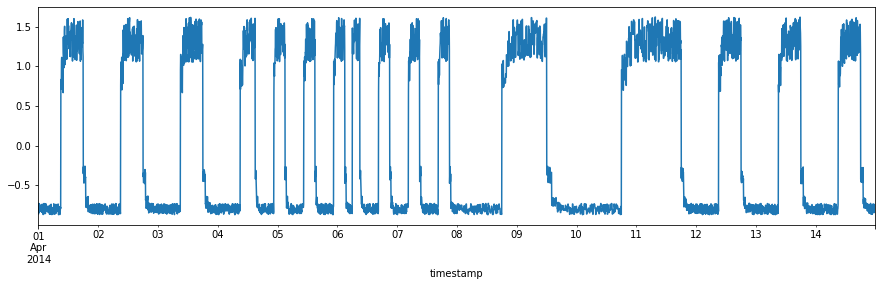

In [ ]:
df_parts = np.array_split(df_training, 4)

values1 = df_parts[1].value.values
values2x = np.concatenate([values1, values1])[::2]
df_parts[1].value = values2x

values2 = df_parts[2].value.values
values05x = np.repeat(values2, 2)[:len(values2)]
df_parts[2].value = values05x

df_testing2 = pd.concat(df_parts)
visualize_timeserie(df_testing2)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



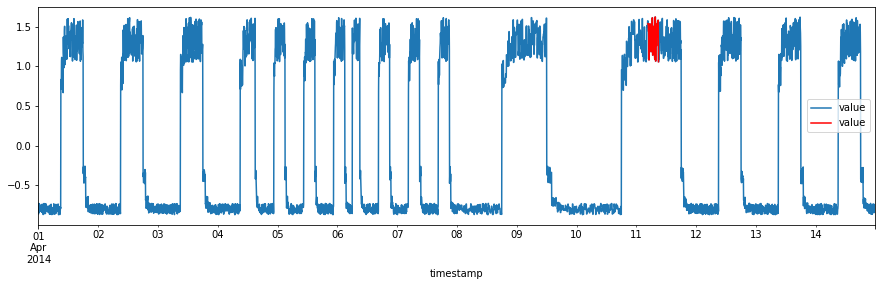

In [ ]:
x_test2 = create_sequences(df_testing2.values)
dataloader_test2 = DataLoader(x_test2, shuffle=False)

test_losses2, test_preds2 = evaluate_model(model=model, dataloader=dataloader_test2)

anomalies2 = test_losses2 > threshold
anomaly_idxs2 = get_anomaly_idxs(dataloader_test2, anomalies2)
df_anomaly2 = df_testing2.iloc[anomaly_idxs2]

fig, ax = plt.subplots(figsize=(15, 4))
df_testing2.plot(ax=ax)
df_anomaly2.plot(ax=ax, color='red')
plt.show()

**:(**